In [26]:
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import math
from astropy import time, coordinates as coord, units as u
import requests
import matplotlib.dates as mdates
from pandas.plotting import table

Path to PixInsight photometry result files

In [27]:
target="RZ Cep"
path="D:\\Astronomie\\SharpCap Captures\\20240919\\rz cep\\work\\photometry"
filelist=os.listdir(path)

Get AAVSO data from target variable

In [28]:
response = requests.get(f"http://www.aavso.org/vsx/index.php?view=api.object&ident={target}&format=json")   
vsx_data=response.json()['VSXObject']
vsx_data

{'Name': 'RZ Cep',
 'AUID': '000-BDC-590',
 'RA2000': '339.80492',
 'Declination2000': '64.85850',
 'ProperMotionRA': '92.6330',
 'ProperMotionDec': '190.7280',
 'VariabilityType': 'RRC/BL:',
 'Period': '0.30862741',
 'Epoch': '2454388.0832',
 'RiseDuration': '32',
 'MaxMag': '9.15 V',
 'MinMag': '9.72 V',
 'SpectralType': 'A0-F2',
 'Discoverer': 'Henrietta Leavitt (1907)',
 'Category': 'Variable',
 'OID': '8370',
 'Constellation': 'Cep'}

In [29]:
constellation=vsx_data['Constellation']
star=vsx_data['Name']
period= vsx_data['Period']
position = coord.SkyCoord(vsx_data['RA2000'],vsx_data['Declination2000'],
                        unit=(u.deg, u.deg), frame='icrs')
observatory = coord.EarthLocation(lat=51.43, lon=6.82, height=40)

Get Photometry field from AAVSO

In [30]:
response = requests.get(f"https://www.aavso.org/vsp/api/chart/?star={star}&fov=60&maglimit=15&format=json")
chart_data=response.json()
chart_data

{'chartid': 'X38802II',
 'image_uri': 'https://apps.aavso.org/vsp/chart/X38802II.png?format=json',
 'star': 'RZ Cep',
 'fov': 60.0,
 'maglimit': 15.0,
 'title': '',
 'comment': '',
 'resolution': 150,
 'dss': False,
 'special': None,
 'photometry': [{'auid': '000-BMW-329',
   'ra': '22:40:38.23',
   'dec': '65:15:45.2',
   'label': '85',
   'bands': [{'band': 'V', 'mag': 8.487, 'error': 0.037},
    {'band': 'B', 'mag': 8.876, 'error': 0.038}],
   'comments': ''},
  {'auid': '000-BMW-330',
   'ra': '22:40:52.11',
   'dec': '65:12:54.4',
   'label': '90',
   'bands': [{'band': 'V', 'mag': 8.97, 'error': 0.039},
    {'band': 'B', 'mag': 9.336, 'error': 0.044}],
   'comments': ''},
  {'auid': '000-BMW-331',
   'ra': '22:38:27.89',
   'dec': '64:31:46.5',
   'label': '96',
   'bands': [{'band': 'V', 'mag': 9.589, 'error': 0.056},
    {'band': 'B', 'mag': 10.003, 'error': 0.057}],
   'comments': ''},
  {'auid': '000-BMW-332',
   'ra': '22:38:07.95',
   'dec': '64:46:00.5',
   'label': '102',

In [31]:
auid_list = []
for photometry_data in chart_data['photometry']:
    auid = photometry_data['auid']
    ra=photometry_data['ra']
    dec=photometry_data['dec']
    for band_data in photometry_data['bands']:
        if band_data['band'] == 'V':
            mag = band_data['mag']
            auid_list.append((auid, ra, dec, mag))

In [32]:
auid_list

[('000-BMW-329', '22:40:38.23', '65:15:45.2', 8.487),
 ('000-BMW-330', '22:40:52.11', '65:12:54.4', 8.97),
 ('000-BMW-331', '22:38:27.89', '64:31:46.5', 9.589),
 ('000-BMW-332', '22:38:07.95', '64:46:00.5', 10.222),
 ('000-BMW-333', '22:40:23.27', '65:11:21.9', 10.352),
 ('000-BMW-334', '22:40:05.51', '64:57:19.1', 10.866),
 ('000-BPK-982', '22:37:53.32', '64:22:52.6', 14.857)]

Match with PixInsight Photometry Table

In [33]:
file=filelist[0]
df=pd.read_csv(path+"\\"+file,sep=";",skiprows=5)
df.columns = df.columns.str.replace(' ', '')
names= df[['NAME']].to_numpy()
catalogue= df[['CATRA', 'CATDEC']].to_numpy()
flags= df[['FLAG']].to_numpy() 
catalogue=coord.SkyCoord(catalogue[:,0],catalogue[:,1],unit=(u.deg, u.deg), frame='icrs')

In [34]:
idx,d2d,d3d=position.match_to_catalog_sky(catalogue)
varstar=names[idx][0].replace(" ", "")
varstar

'3UCAC310-119181'

In [35]:
star_data=np.array([(tup[1], tup[2]) for tup in auid_list])
star_coord=coord.SkyCoord(star_data[:,0],star_data[:,1],unit=(u.hourangle, u.deg), frame='icrs')

In [36]:
idx,d2d,d3d=star_coord.match_to_catalog_sky(catalogue)

In [37]:
d2d

<Angle [0.04114752, 0.01904729, 0.00087789, 0.0004394 , 0.00032132,
        0.00028561, 0.13016107] deg>

In [38]:
df.iloc[idx]

,DATE_OBS,NAME,FILTER,CATRA,CATDEC,IMGRA,IMGDEC,IMGX,IMGY,f.mag,...,SNR10,SNR11,SNR12,SNR13,SNR14,SNR15,SNR16,SNR17,SNR18,FLAG
28,2.460574e+06,3UCAC311-110033,Johnson V,340.084557,65.235833,340.084629,65.235829,2997.499,235.532,11.153,...,273.19900,263.63550,253.75030,244.01170,234.54520,225.53890,216.76530,208.57490,201.15070,0000
282,2.460574e+06,3UCAC311-110122,Johnson V,340.212735,65.196153,340.212728,65.196136,2717.872,211.674,13.994,...,24.52005,22.61211,21.05952,19.78089,18.74449,17.54808,16.62589,15.92151,15.17197,0000
3,2.460574e+06,3UCAC310-119077,Johnson V,339.617813,64.530126,339.617903,64.530090,1676.158,3018.435,9.358,...,711.26870,704.66920,696.53730,687.41790,677.62360,667.35370,656.65520,645.65760,634.43580,0000
8,2.460574e+06,3UCAC310-119007,Johnson V,339.534070,64.766981,339.534229,64.766967,2440.957,2363.505,9.968,...,497.97560,489.22930,479.37070,469.03350,458.39360,447.44720,436.46760,425.63800,415.05370,0000
9,2.460574e+06,3UCAC311-110043,Johnson V,340.096213,65.189343,340.096243,65.189323,2853.095,369.035,10.189,...,459.71140,450.53380,440.69670,430.36650,419.75680,409.06560,398.42480,387.95370,377.66130,0000
17,2.460574e+06,3UCAC310-119317,Johnson V,340.022309,64.955228,340.022439,64.955242,2302.555,1195.037,10.721,...,329.82740,320.03430,309.94500,299.76460,289.78650,280.13580,270.87000,261.92690,253.34140,0000
295,2.460574e+06,3UCAC309-129190,Johnson V,339.773163,64.379505,339.773172,64.379493,1048.072,3313.008,14.054,...,22.70400,20.78618,19.20603,17.85592,16.57206,15.68691,14.94048,14.00727,13.38212,0000


In [39]:
photometry_stars=[]
photometry_mags=[]
for i in range(len(auid_list)):
    if flags[idx[i]] == "0000" and d2d[i].arcsec < 10.0:
        photometry_stars.append(names[idx[i]][0].replace(" ", ""))
        photometry_mags.append(auid_list[i][3])

In [40]:
photometry_stars, photometry_mags

(['3UCAC310-119077', '3UCAC310-119007', '3UCAC311-110043', '3UCAC310-119317'],
 [9.589, 10.222, 10.352, 10.866])

In [41]:

check=photometry_stars[3]
compstar=photometry_stars[0:3]
compstar_mag=photometry_mags[0:3]

In [42]:
check

'3UCAC310-119317'

In [43]:
file=filelist[0]
df=pd.read_csv(path+"\\"+file,sep=";",skiprows=5)
df

,DATE_OBS,NAME,FILTER,CATRA,CATDEC,IMGRA,IMGDEC,IMGX,IMGY,f.mag,...,SNR10,SNR11,SNR12,SNR13,SNR14,SNR15,SNR16,SNR17,SNR18,FLAG
0,2.460574e+06,3UCAC310-119695,Johnson V,340.571192,64.872031,340.571293,64.871991,1338.218,809.063,6.793,...,1656.55000,1665.74900,1670.64700,1672.29300,1671.88200,1669.76600,1666.48200,1662.07500,1656.75300,0010
1,2.460574e+06,3UCAC311-109367,Johnson V,339.178043,65.257768,339.178219,65.257760,4264.321,1209.774,7.411,...,1548.23700,1553.95500,1555.61500,1554.96600,1552.53400,1548.81900,1543.94600,1538.14700,1531.56900,0010
2,2.460574e+06,3UCAC310-119181,Johnson V,339.806417,64.859810,339.806538,64.859785,2328.477,1750.051,9.028,...,696.83340,690.40150,682.37660,673.19590,663.11230,652.57540,641.78700,630.83550,619.73110,0000
3,2.460574e+06,3UCAC310-119077,Johnson V,339.617813,64.530126,339.617903,64.530090,1676.158,3018.435,9.358,...,711.26870,704.66920,696.53730,687.41790,677.62360,667.35370,656.65520,645.65760,634.43580,0000
4,2.460574e+06,3UCAC311-109604,Johnson V,339.467425,65.384685,339.467439,65.384673,4226.637,473.854,9.435,...,731.02280,724.91590,717.29790,708.60050,699.09120,689.01160,678.47770,667.56330,656.34230,0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,2.460574e+06,3UCAC309-129687,Johnson V,340.341711,64.369768,340.341850,64.369804,243.323,2661.818,14.470,...,18.17045,16.41469,15.40727,14.51682,13.47233,12.57895,11.82818,11.17955,10.72095,0000
407,2.460574e+06,3UCAC309-129270,Johnson V,339.862530,64.343329,339.862490,64.343315,825.377,3321.242,14.482,...,17.66683,16.19381,14.77437,13.66715,12.95905,12.55221,12.13940,11.50763,10.76535,0000
408,2.460574e+06,3UCAC311-109357,Johnson V,339.164793,65.084191,339.164764,65.084225,3808.325,1780.284,14.483,...,16.09452,14.91607,13.87602,12.79579,11.51847,10.38051,9.47396,8.80770,8.48132,0000
409,2.460574e+06,3UCAC310-118539,Johnson V,338.753727,64.846709,338.753951,64.846729,3721.163,3014.350,14.485,...,16.30779,14.98201,13.68282,12.28977,11.04665,10.21500,9.92977,9.84827,9.41501,0000


In [44]:
t0=df.iloc[0,0]
t0_iso=time.Time(t0,format="jd")

In [45]:
l=[]
for s in df.iloc[:,1]: l=l+[s.strip()]
df.iloc[:,1]=l

In [46]:
def snrlst(target,infiles):
    target_snr=[]
    for file in infiles:
        df=pd.read_csv(path+"\\"+file,sep=";",skiprows=5)
         #find target star
        l=[]
        for s in df.iloc[:,1]: l=l+[s.strip()]
        df.iloc[:,1]=l
        itarget=(df.iloc[:,1]==target)
        target_snr=target_snr+[df.loc[itarget]]
    target_snr=pd.concat(target_snr,ignore_index=True)
    ind=[]
    col=target_snr.columns.to_list()
    for s in col:
        ind = ind + [s.startswith("SNR")]
    target_snr=target_snr.loc[:,ind]
    return target_snr.mean()

In [47]:
snr=snrlst(varstar,filelist)
snrmax=snr.idxmax()
labelflux=snrmax.replace("SNR","FLUX")
labelflux

'FLUX9    '

In [48]:
def fluxcalc2(target,infiles,label_max):
    target_flux=pd.DataFrame()
    for file in infiles:
        #read file
        df=pd.read_csv(path+"\\"+file,sep=";",skiprows=5)
        #find target star
        l=[]
        for s in df.iloc[:,1]: l=l+[s.strip()]
        df.iloc[:,1]=l
        itarget=(df.iloc[:,1]==target)
        #read flux
        flux=df.loc[itarget][['DATE_OBS     ',label_max]]
        flux=flux.rename(columns={'DATE_OBS     ':"DATE_OBS",label_max:"FLUX"})
        target_flux=pd.concat([target_flux,flux])
    target_flux=target_flux.reset_index(drop=True)
    return target_flux

In [49]:
minind=0
maxind=len(filelist)

In [50]:
flux_var=fluxcalc2(varstar,filelist,labelflux)
flux_check=fluxcalc2(check,filelist,labelflux)

In [51]:
flux_comp=pd.DataFrame()
flux_comp["DATE_OBS"]=flux_var["DATE_OBS"]
flux_comp=flux_comp.reset_index(drop=True)
for star in compstar:
    flux=fluxcalc2(star,filelist,labelflux)
    #flux = flux.reset_index(drop=True)
    flux_comp[star]=flux['FLUX']
print(flux_comp)   

         DATE_OBS  3UCAC310-119077  3UCAC310-119007  3UCAC311-110043
0    2.460574e+06        581983.90        318272.21        280327.20
1    2.460574e+06        576164.54        317679.01        281228.55
2    2.460574e+06        596752.79        331186.81        282644.93
3    2.460574e+06        588306.94        321806.80        283020.98
4    2.460574e+06        572166.59        316066.66        276841.70
..            ...              ...              ...              ...
297  2.460575e+06        580227.93        317411.30        272660.18
298  2.460575e+06        575816.48        313219.04        274015.85
299  2.460575e+06        586855.03        323183.50        280246.33
300  2.460575e+06        580045.60        322592.17        277697.83
301  2.460575e+06        575136.22        318258.74        267475.23

[302 rows x 4 columns]


In [52]:
t=flux_var.to_numpy()[minind:maxind,0]
mag_var=flux_var.to_numpy()[minind:maxind,1]
mag_check=flux_check.to_numpy()[minind:maxind,1]
mag_comp=flux_comp.to_numpy()[minind:maxind,1:]

In [53]:
nstars = mag_comp.shape[1]+2
nstars

5

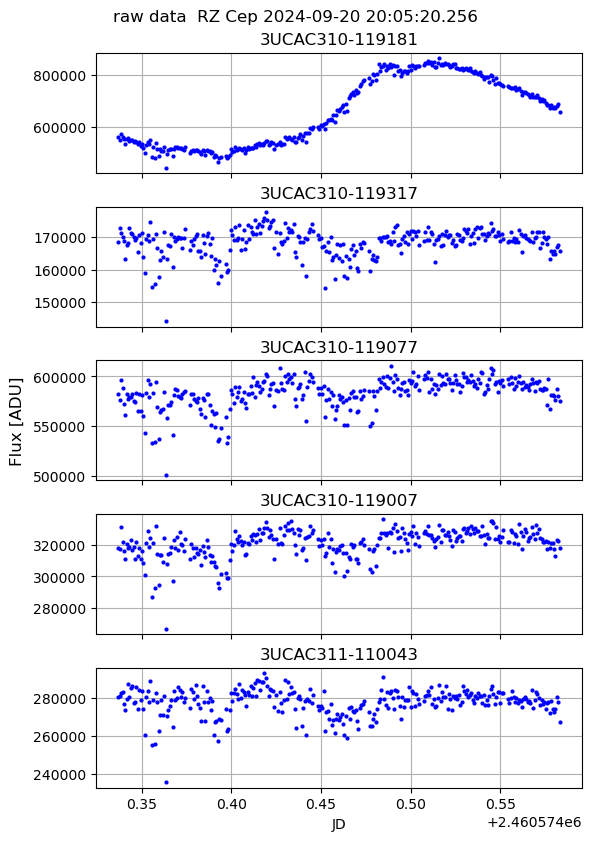

In [54]:
fig, ax = plt.subplots(nstars,1,figsize=(5.8,8.3), layout='constrained')
fig.suptitle("raw data " + " " + target + " " + t0_iso.iso )
fig.supylabel("Flux [ADU]")
ax[0].plot(t,mag_var,"bo",ms=2)
ax[0].set_title(varstar)
ax[0].tick_params(axis="x",labelbottom=False)
ax[0].grid(visible="true")
ax[1].plot(t,mag_check,"bo",ms=2)
ax[1].set_title(check)
ax[1].grid(visible="true")
ax[1].tick_params(axis="x",labelbottom=False)
for i in range(2,nstars):
    ax[i].plot(t,mag_comp[:,i-2],"bo",ms=2)
    ax[i].set_title(compstar[i-2])
    ax[i].grid(visible="true")
    ax[i].tick_params(axis="x",labelbottom=False)
ax[nstars-1].set_xlabel("JD")
ax[nstars-1].tick_params(axis="x",labelbottom=True)

fig.savefig(constellation+"_"+target.replace(constellation, "")+"_"+'%-8.4f'%(t0_iso.to_value("jd")-2400000)+"_"+"RAW_DATA"+".pdf", format="pdf")

In [55]:
# Create a new DataFrame with the same column names as flux_comp
mag_var = pd.DataFrame({'DATE_OBS': flux_comp['DATE_OBS']})

# Calculate the new columns
for star, mag0 in zip(compstar, compstar_mag):
    mag_var[star] = -2.5 * np.log10(flux_var['FLUX'] / flux_comp[star]) + mag0

print(mag_var)

         DATE_OBS  3UCAC310-119077  3UCAC310-119007  3UCAC311-110043
0    2.460574e+06         9.629498         9.607217         9.599384
1    2.460574e+06         9.643597         9.630202         9.627879
2    2.460574e+06         9.636837         9.630533         9.588454
3    2.460574e+06         9.645985         9.623963         9.614522
4    2.460574e+06         9.628312         9.616953         9.603085
..            ...              ...              ...              ...
297  2.460575e+06         9.421976         9.400035         9.365034
298  2.460575e+06         9.418248         9.390158         9.374977
299  2.460575e+06         9.426965         9.412261         9.387488
300  2.460575e+06         9.405512         9.401491         9.368788
301  2.460575e+06         9.446132         9.436656         9.377914

[302 rows x 4 columns]


In [56]:
# Identify the columns to be averaged (all columns except 'date_obs')
columns_to_average = mag_var.columns.difference(['DATE_OBS'])

# Calculate the row-wise mean for these columns
mag_var['average'] = mag_var[columns_to_average].mean(axis=1)

mag_var

,DATE_OBS,3UCAC310-119077,3UCAC310-119007,3UCAC311-110043,average
0,2.460574e+06,9.629498,9.607217,9.599384,9.612033
1,2.460574e+06,9.643597,9.630202,9.627879,9.633892
2,2.460574e+06,9.636837,9.630533,9.588454,9.618608
3,2.460574e+06,9.645985,9.623963,9.614522,9.628157
4,2.460574e+06,9.628312,9.616953,9.603085,9.616117
...,...,...,...,...,...
297,2.460575e+06,9.421976,9.400035,9.365034,9.395682
298,2.460575e+06,9.418248,9.390158,9.374977,9.394461
299,2.460575e+06,9.426965,9.412261,9.387488,9.408904
300,2.460575e+06,9.405512,9.401491,9.368788,9.391930


In [57]:
mag = mag_var['average'].to_numpy()
mag.shape

(302,)

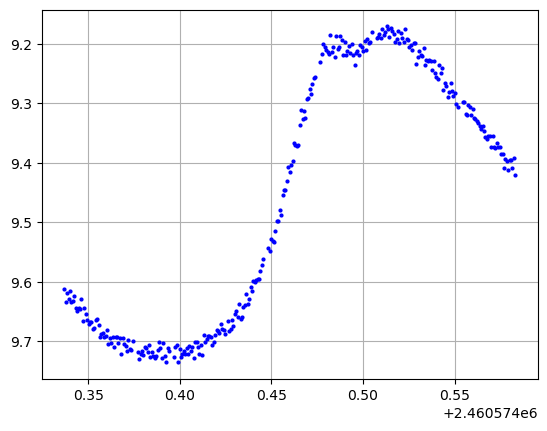

In [58]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(t,mag,"bo",ms=2)  # Plot some data on the axes.
#ax.set_ylim(12.7,12.8)
ax.invert_yaxis()
ax.grid(visible=True)

In [59]:
# Create a new DataFrame with the same column names as flux_comp
mag_check = pd.DataFrame({'DATE_OBS': flux_comp['DATE_OBS']})

# Calculate the new columns
for star, mag0 in zip(compstar, compstar_mag):
    mag_check[star] = -2.5 * np.log10(flux_check['FLUX'] / flux_comp[star]) + mag0

print(mag_check)

         DATE_OBS  3UCAC310-119077  3UCAC310-119007  3UCAC311-110043
0    2.460574e+06        10.933802        10.911521        10.903688
1    2.460574e+06        10.896014        10.882619        10.880296
2    2.460574e+06        10.944628        10.938324        10.896244
3    2.460574e+06        10.935998        10.913976        10.904534
4    2.460574e+06        10.913396        10.902036        10.888168
..            ...              ...              ...              ...
297  2.460575e+06        10.948671        10.926730        10.891729
298  2.460575e+06        10.947502        10.919412        10.904231
299  2.460575e+06        10.954161        10.939457        10.914684
300  2.460575e+06        10.937518        10.933497        10.900794
301  2.460575e+06        10.939375        10.929899        10.871157

[302 rows x 4 columns]


In [60]:
# Identify the columns to be averaged (all columns except 'date_obs')
columns_to_average = mag_check.columns.difference(['DATE_OBS'])

# Calculate the row-wise mean for these columns
mag_check['average'] = mag_check[columns_to_average].mean(axis=1)

mag_check

,DATE_OBS,3UCAC310-119077,3UCAC310-119007,3UCAC311-110043,average
0,2.460574e+06,10.933802,10.911521,10.903688,10.916337
1,2.460574e+06,10.896014,10.882619,10.880296,10.886310
2,2.460574e+06,10.944628,10.938324,10.896244,10.926399
3,2.460574e+06,10.935998,10.913976,10.904534,10.918169
4,2.460574e+06,10.913396,10.902036,10.888168,10.901200
...,...,...,...,...,...
297,2.460575e+06,10.948671,10.926730,10.891729,10.922377
298,2.460575e+06,10.947502,10.919412,10.904231,10.923715
299,2.460575e+06,10.954161,10.939457,10.914684,10.936101
300,2.460575e+06,10.937518,10.933497,10.900794,10.923936


In [61]:
mag_c = mag_check['average'].to_numpy()
mag.shape

(302,)

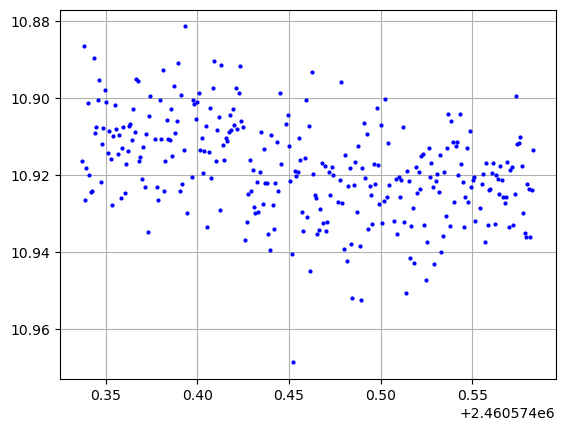

In [62]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(t,mag_c,"bo",ms=2)  # Plot some data on the axes.
ax.grid(visible=True)
#ax.set_ylim(12.4,12.5)
ax.invert_yaxis()

In [63]:
err_c=np.std(mag_c)
err_c

0.012781578340284433

In [64]:
lc=np.empty((mag.shape[0],3))
lc[:,0]=t
lc[:,1]=mag
lc[:,2]=err_c

In [65]:
t0=int(lc[0,0])
t=lc[:,0]-t0
mag=lc[:,1]
merr=lc[:,2]

In [66]:
t0_ap=time.Time(t0,format="jd")
t0_ap.to_value("iso",subfmt="date")

'2024-09-20'

In [67]:
p=float(period)
w=2*math.pi/p
k=8
C=np.stack([np.sin(i*w*t) for i in range(1,k+1)])
B=np.stack([np.cos(i*w*t) for i in range(k+1)])
A=np.concatenate((B,C)).T
coeff = np.linalg.lstsq(A,mag,rcond=None)[0]

In [68]:
def lc_fourier(t,w,coeff):
    n=coeff.shape[0]
    mag=0
    k=int((n-1)/2)
    for i in range(0,k+1):
        mag=mag+coeff[i]*np.cos(i*w*t)
    for i in range(k+1,n):
        mag=mag+coeff[i]*np.sin((i-k)*w*t)
    return mag

In [69]:
t_step=np.linspace(min(t),max(t),1000)

In [70]:
x=lc_fourier(t_step,w,coeff)

In [71]:
ind=sp.signal.argrelmin(x)
ind1=sp.signal.argrelmax(x)

In [72]:
ind1

(array([215, 643], dtype=int64),)

In [73]:
t0_ap=time.Time(t0+t_step[ind],format="jd")
t1_ap=time.Time(t0+t_step[ind1],format="jd")
t0_ap.to_value("iso")

array(['2024-09-20 23:41:43.694', '2024-09-21 00:23:35.244'], dtype='<U23')

In [74]:
t0_ap = time.Time(t0+t_step[ind],format="jd",
                  scale='utc', location=observatory)  
t1_ap=time.Time(t0+t_step[ind1],format="jd",
                  scale="utc",location=observatory)
ltt0_helio = t0_ap.light_travel_time(position,"heliocentric") 
ltt1_helio = t1_ap.light_travel_time(position,"heliocentric") 
ltt0_helio.to_value("jd") 

array([0.00226898, 0.00226964])

In [75]:
time.Time(t0+t_step[ind],format="jd",
                  scale='utc', location=observatory)  

<Time object: scale='utc' format='jd' value=[2460574.48731127 2460574.51638014]>

In [76]:
t_am=time.Time(t0+t_step,format="jd",scale="utc",location=observatory)
frame=coord.AltAz(obstime=t_am,location=observatory)
airmass=position.transform_to(frame).secz
[airmass[0],airmass[999],np.min(airmass)]

[<Quantity 1.07195282>, <Quantity 1.17447565>, <Quantity 1.02867025>]

In [77]:
description=[["Maximum (UTC, geocentric)",t0_ap[0].to_value("iso")],
             ["Maximum (HJD, time base UTC)",'%-8.4f'%(t0_ap[0].to_value("jd")+ltt0_helio[0].to_value("jd"))+"+/-0.002"],
             ["Maximum (UTC, geocentric)",t0_ap[1].to_value("iso")],
             ["Maximum (HJD, time base UTC)",'%-8.4f'%(t0_ap[1].to_value("jd")+ltt0_helio[1].to_value("jd"))+"+/-0.002"],
             ["Minimum (UTC, geocentric)",t1_ap[0].to_value("iso")],
             ["Minimim (HJD, time base UTC)",'%-8.4f'%(t1_ap[0].to_value("jd")+ltt1_helio[0].to_value("jd"))+"+/-0.002"],
             ["Minimum (UTC, geocentric)",t1_ap[1].to_value("iso")],
             ["Minimim (HJD, time base UTC)",'%-8.4f'%(t1_ap[1].to_value("jd")+ltt1_helio[1].to_value("jd"))+"+/-0.002"],
             ["Observer","Deeskow, DES"],
             ["Instrumnent","CFF140 f/6.6, ASI1600mm with V Filter"],
             ["Comparison Star",compstar[0]],
             ["",compstar[1]],
             ["",compstar[2]],
             ["Photometry","PixInsight Photometry Skript"],
             ["Evaluation","Fourier-Fit"],
             ["Airmass","1.072 ... 1.028 ... 1.174"],
             ["Number of Measurements",str(lc.shape[0])]
            ]
title=target + " " + "             "+t0_ap[0].to_value("iso",subfmt="date")

In [78]:
tiso=time.Time(t0+t,format="jd")
t_step_iso=time.Time(t0+t_step,format="jd")
jd0=t_step_iso[0].jd

In [79]:
mpl0=mpl.dates.date2num(t_step_iso[0].datetime)

In [80]:
def jd2mpl(tin):
    tout=tin+mpl0-jd0-ltt0_helio[0].to_value("jd")+int(jd0)
    return tout

In [81]:
def mpl2jd(tin):
    tout=tin-mpl0+jd0+ltt0_helio[0].to_value("jd")-int(jd0) 
    return tout

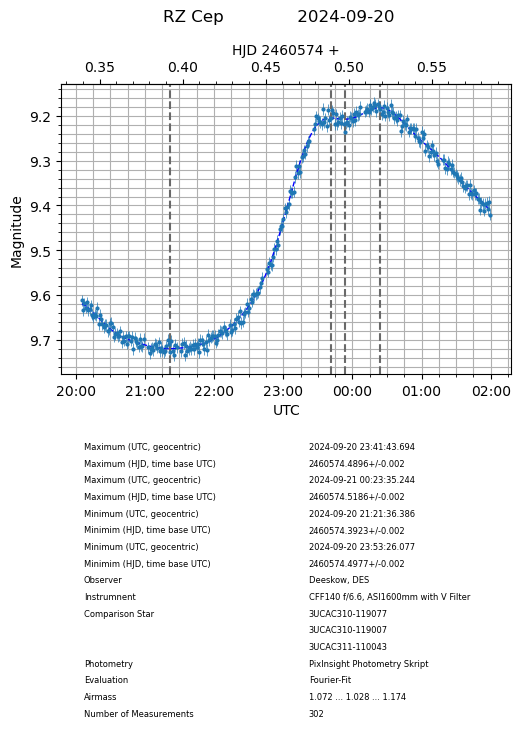

In [82]:
fig, (ax,ax1) = plt.subplots(2,1,height_ratios=[1,1],figsize=(5.8,8.3))
fig.suptitle(title,x=0.5,y=0.97,ha="center")
ax.clear()
ax.errorbar(tiso.datetime,mag,yerr=merr,elinewidth=0.5,marker="o",ms=2,linestyle="none")
ax.plot(t_step_iso.datetime,lc_fourier(t_step,w,coeff),"b--",linewidth=1)  
for i in ind[0]:
    ax.axvline(t_step_iso[i].datetime,0,1,color='dimgrey',ls="--")
for i in ind1[0]:
    ax.axvline(t_step_iso[i].datetime,0,1,color='dimgrey',ls="--")
ax.invert_yaxis()
ax.minorticks_on()
ax.grid(visible=True,which="both")
ax.set_xlabel("UTC")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#ax.set_xlabel("JD "+'%-8.0f'%(int(t0_ap.to_value("jd"))))
ax.set_ylabel("Magnitude")

secax = ax.secondary_xaxis('top', functions=(mpl2jd,jd2mpl))
secax.set_xlabel('HJD'+" "+str(int(jd0))+" +")
#pticks=ax.get_xticks()
#secax.set_xticks(mpl2jd(pticks))
secax.minorticks_on()

ax1.tick_params(
    axis="both",
    which="both",
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labeltop=False,
    labelleft=False,
    labelright=False)
ax1.set_axis_off()
ax1.table(description,loc="upper center",cellLoc="left",edges="")

fig.savefig(constellation+"_"+target.replace(constellation, "")+"_"+'%-8.4f'%(t0_ap[1].jd-2400000+ltt0_helio[1].to_value("jd"))+"_"+"DES"+".pdf", format="pdf")
    

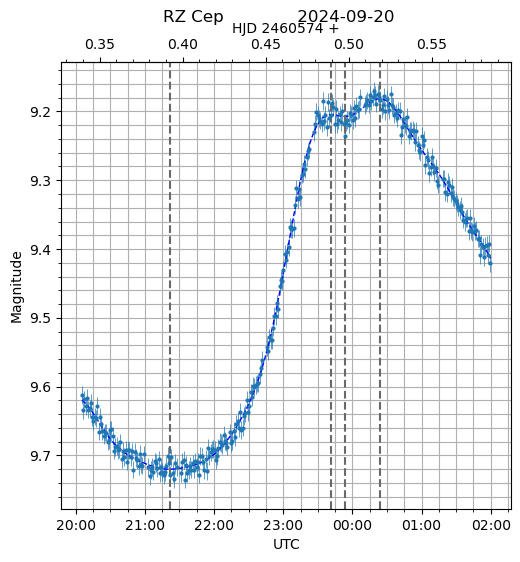

In [83]:
fig, ax = plt.subplots(1,1,height_ratios=[1],figsize=(5.8,5.8))
fig.suptitle(title,x=0.5,y=0.97,ha="center")
ax.clear()
ax.errorbar(tiso.datetime,mag,yerr=merr,elinewidth=0.5,marker="o",ms=2,linestyle="none")
ax.plot(t_step_iso.datetime,lc_fourier(t_step,w,coeff),"b--",linewidth=1)  
for i in ind[0]:
    ax.axvline(t_step_iso[i].datetime,0,1,color='dimgrey',ls="--")
for i in ind1[0]:
    ax.axvline(t_step_iso[i].datetime,0,1,color='dimgrey',ls="--")
ax.invert_yaxis()
ax.minorticks_on()
ax.grid(visible=True,which="both")
ax.set_xlabel("UTC")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#ax.set_xlabel("JD "+'%-8.0f'%(int(t0_ap.to_value("jd"))))
ax.set_ylabel("Magnitude")

secax = ax.secondary_xaxis('top', functions=(mpl2jd,jd2mpl))
secax.set_xlabel('HJD'+" "+str(int(jd0))+" +")
#pticks=ax.get_xticks()
#secax.set_xticks(mpl2jd(pticks))
secax.minorticks_on()


fig.savefig(constellation+"_"+target.replace(constellation, "")+"_"+'%-8.4f'%(t0_ap[1].jd-2400000+ltt0_helio[1].to_value("jd"))+"_"+"DES"+".png", format="png")
    

In [84]:
maxlist=[]
for i in range(t0_ap.shape[0]): 
    maximum=[constellation,
         target.replace(constellation, ""),
         "max",
         '%-8.4f'%(t0_ap[i].to_value("jd")),
         '%-8.4f'%(t0_ap[i].to_value("jd")+ltt0_helio[i].to_value("jd")),
         '0.002',
         "na",
         "na",
         '%-6.3f'%(lc_fourier(t0_ap[i].jd-t0,w,coeff)),
         "C",
         "ASI1600MM",
         "V",
         str(lc.shape[0]),
         "DES",
         "na"
        ]
    maxout=""
    for entry in maximum:
        maxout=maxout+entry+"|"
    maxlist=maxlist+[maxout]   
        
maxlist

['Cep|RZ |max|2460574.4873|2460574.4896|0.002|na|na|9.205 |C|ASI1600MM|V|302|DES|na|',
 'Cep|RZ |max|2460574.5164|2460574.5186|0.002|na|na|9.182 |C|ASI1600MM|V|302|DES|na|']

In [85]:
minlist=[]
for i in range(t1_ap.shape[0]):
    minimum=[constellation,
         target.replace(constellation, ""),
         "min",
         '%-8.4f'%(t1_ap[i].to_value("jd")),
         '%-8.4f'%(t1_ap[i].to_value("jd")+ltt1_helio[i].to_value("jd")),
         '0.002',
         "na",
         "na",
         '%-6.3f'%(lc_fourier(t1_ap[i].jd-t0,w,coeff)),
         "C",
         "ASI1600MM",
         "V",
         str(lc.shape[0]),
         "DES",
         "na"
        ]
    minout=""
    for entry in minimum:
        minout=minout+entry+"|"
    minlist=minlist+[minout]  
minlist

['Cep|RZ |min|2460574.3900|2460574.3923|0.002|na|na|9.720 |C|ASI1600MM|V|302|DES|na|',
 'Cep|RZ |min|2460574.4954|2460574.4977|0.002|na|na|9.207 |C|ASI1600MM|V|302|DES|na|']

In [86]:
f=open(constellation+"_"+target.replace(constellation, "")+"_"+'%-8.4f'%(t0_ap[i].jd-2400000+ltt0_helio[i].to_value("jd"))+"_"+"DES"+"_MiniMax"+".txt","w")
f.write("#TYPE=BAVMiniMax")
f.write("\n")
f.write("#Delim=|")
f.write("\n")
for line in maxlist:
    f.write(line)
    f.write("\n")
for line in minlist:
    f.write(line)
    f.write("\n")
f.close()

In [87]:
np.savetxt(constellation+"_"+target.replace(constellation, "")+"_"+'%-8.4f'%(t0_ap[0].jd-2400000+ltt0_helio[0].to_value("jd"))+"_"+"DES"+"_BAVReport"+".txt",lc,fmt="%-8.4f",header="BAV-Report"+"\n"+"Rem=")

In [88]:
data=np.array([(2442635.374,2448500.0334,2454388.5221,2454388.0832),(0.30864291,0.3086876,0.308626840,0.30862741)])
data=np.transpose(data)

In [89]:
data=np.array([(2442635.374,2448500.0334,2446342.6620,2454388.0832),(0.30864291,0.3086876,0.30868420,0.30862741)])
data=np.transpose(data)

In [90]:
elements=pd.DataFrame(data,columns=["epoch","period"],index=["AAVSO","GCVS","BAV","DES"])

In [91]:
elements

,epoch,period
AAVSO,2.442635e+06,0.308643
GCVS,2.448500e+06,0.308688
BAV,2.446343e+06,0.308684
DES,2.454388e+06,0.308627


In [92]:
tmax=(t0_ap[1].to_value("jd")+ltt0_helio[1].to_value("jd"))

In [93]:
oc=pd.DataFrame(data=None,index=["AAVSO","GCVS","BAV","DES"],columns=["O-C"])
for dataset in elements.itertuples():
    e=int((tmax-dataset.epoch)/dataset.period)
    oc0=tmax-(dataset.epoch+e*dataset.period)
    oc1=tmax-(dataset.epoch+(e+1)*dataset.period)
    if abs(oc0) < abs(oc1):
        oc.loc[dataset.Index]["O-C"]=oc0
    else:
        oc.loc[dataset.Index]["O-C"]=oc1
oc

,O-C
AAVSO,-0.107208
GCVS,-0.138912
BAV,-0.028391
DES,-0.000984


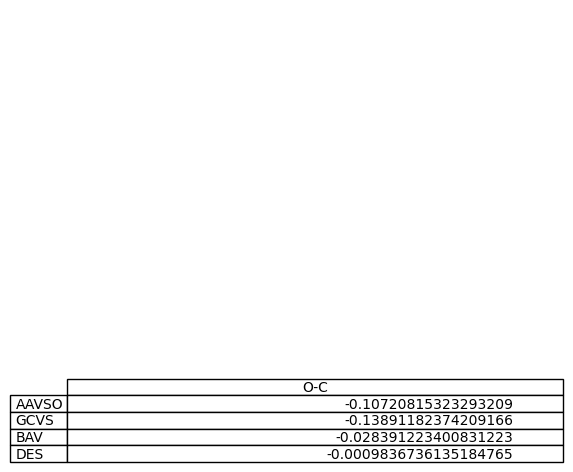

In [94]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, oc)  # where df is your data frame

plt.show()

In [ ]:
pip install astropy

Note: you may need to restart the kernel to use updated packages.
